# Project Part 4 - DATA602

Reynald Oliveria - 116576604

## Importing Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading in Data from Part 3

In [2]:
df = pd.read_csv('enriched_data.csv')
df

,Season,ScoreDiff,Winner,ScoreRegSznDiff,FGMDiff,FGADiff,FGM3Diff,FGA3Diff,FTMDiff,FTADiff,ORDiff,DRDiff,AstDiff,TODiff,StlDiff,BlkDiff,PFDiff,SeedDiff
0,2003,8,0,-1.593103,-0.354023,1.526437,0.549425,-0.500000,-1.434483,-7.135632,-0.890805,-1.627586,-1.165517,0.973563,0.635632,0.766667,0.803448,0.0
1,2003,-29,1,-17.421182,-5.493842,-9.852217,-1.759852,-4.588670,-4.673645,-5.448276,-2.213054,-1.918719,-3.435961,-0.716749,-1.602217,-1.248768,-1.853448,15.0
2,2003,13,0,1.448276,0.931034,-3.103448,-3.000000,-7.482759,2.586207,3.310345,-0.379310,-2.655172,-1.068966,0.206897,-2.172414,-0.827586,0.655172,3.0
3,2003,6,0,0.102403,-2.076280,-4.764890,-1.142111,-2.553814,5.397074,5.142111,-0.292581,0.094044,-1.197492,4.877743,-1.290491,-0.454545,3.692790,5.0
4,2003,2,0,2.082759,3.011494,5.390805,-1.552874,-5.465517,-2.387356,-0.949425,1.508046,2.345977,1.333333,-0.027586,-1.214943,-0.273563,-1.563218,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,2024,-7,1,1.062500,1.781250,-1.687500,1.875000,3.843750,-4.375000,-6.468750,-3.625000,2.937500,0.375000,-0.156250,-3.968750,-0.531250,-6.125000,1.0
1378,2024,6,0,3.925189,1.077652,-3.356061,-0.385417,-5.075758,2.155303,3.812500,0.280303,1.322917,1.643939,1.000947,-2.270833,-0.868371,-3.073864,-1.0
1379,2024,-14,1,9.279412,1.818015,6.102941,2.268382,6.310662,3.375000,3.283088,0.943015,-0.082721,-2.623162,2.694853,1.014706,-1.319853,3.639706,3.0
1380,2024,-13,1,-7.032828,-1.126263,2.578283,-1.277778,-0.035354,-3.502525,-5.194444,-1.974747,-3.083333,-5.699495,-1.747475,1.750000,-0.287879,1.997475,10.0


## Investigating normality

Let's plot the distributions of the continuous variables.

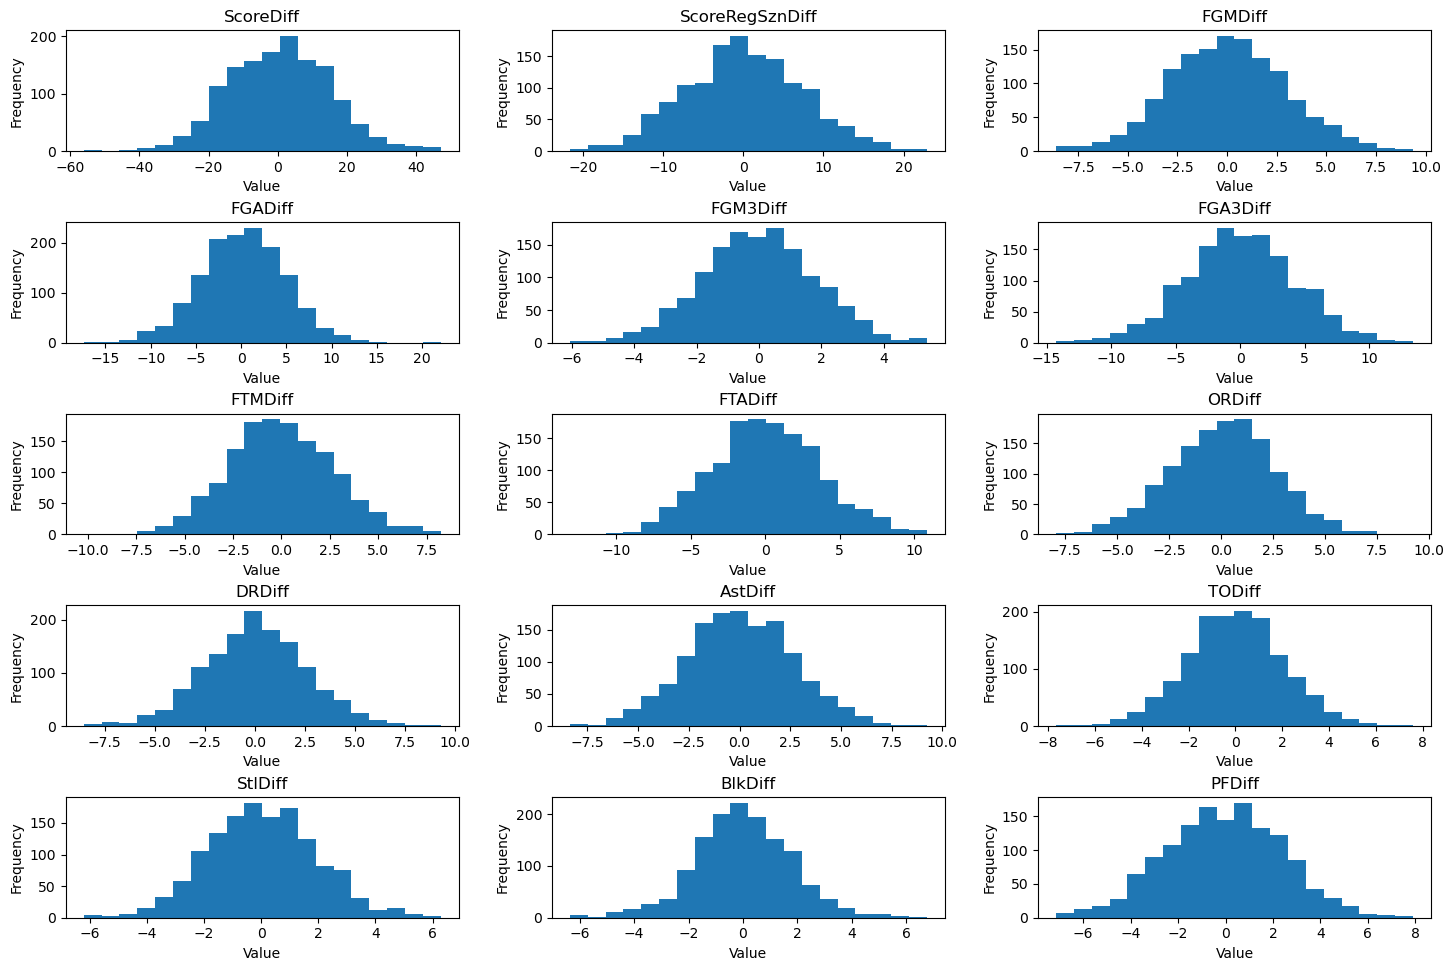

In [3]:
cont_df = df[df.columns[df.columns.str.endswith('Diff')]].drop(columns = 'SeedDiff')
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
fig.tight_layout(pad=3.0)

axes = axes.ravel()

for i, column in enumerate(cont_df.columns):
    axes[i].hist(cont_df[column], bins = 20)
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.show()

We see that they are all roughly normal. This suggests more traditional statistical methods can be used for predictions which give us a robust way to have an input as a distribution and an output as another distribution rather than just simple values. This suggests, logistic and linear regressions may be appropriate.

## Investigating correlations

Let's investigate the $R^2$ between our ordinal/continuous variables.

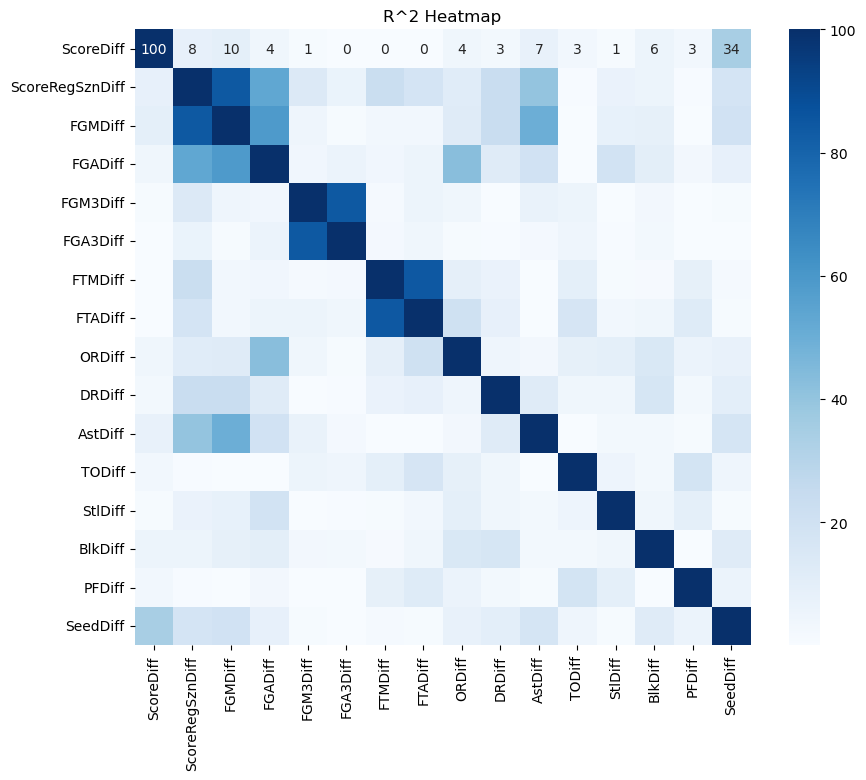

In [4]:
num_df = df[df.columns[df.columns.str.endswith('Diff')]]

correlation_matrix = num_df.corr() ** 2 * 100

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".0f", square=True, cmap = 'Blues')

plt.title('R^2 Heatmap')
plt.show()

`ScoreDiff` is the difference in score for the game that was played during march madness. Because we want to predict the outcome of the game, `ScoreDiff` would probably be our response variable. So we see that the most correlated variable to `ScoreDiff` is `SeedDiff`. Further, we can eliminate using variables like `FGA3Diff`, `FTMDiff`, and `FTADiff` as they have 0 correlation with `ScoreDiff`. Finally, we need to be wary of violating Linear Regression assumptions due to cross collinearity between `ScoreRegSznDiff`, `FGMDiff`, and `FGADiff`.

Also, because most variables have low $R^2$ with each other and with `ScoreDiff`, this suggests that any model we make will need to use many variables. Because of the relatively small number of observations, we need to be wary of overfitting. A penalized regression, like Lasso or ElasticNet maybe necessary. Or, methods robust against overfitting like a RandomForest or Boosted Trees may be used.

## Investigating the predictive power of `SeedDiff`

From above, `SeedDiff` is the highest correlated with `ScoreDiff`. `SeedDiff` is the difference in seed between Team 0 and Team 1. The seed of a team is a reflection of their performance during the regular season. Teams with lower seeds have had a more successful season. A positive `SeedDiff` suggests that Team 0 is seeded worse (higher) in the tournament than Team 1. And so, an upset in the tournmanet, in terms of `SeedDiff`, is a positive `SeedDiff` but Team 0 wins, or a negative `SeedDiff` but Team 1 wins. Let's investigate the predictive power of `SeedDiff` by calculating the proportion of upsets.

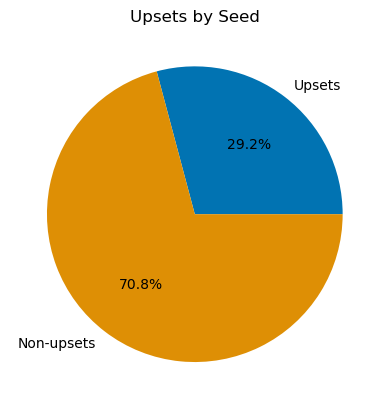

In [5]:
upsets = (((df['SeedDiff'] > 0) & (df['Winner'] == 0)) | ((df['SeedDiff'] < 0) & (df['Winner'] == 1))).sum()
seed_non_ties = (df['SeedDiff'] != 0).sum()

plt.figure()
plt.pie([upsets, seed_non_ties-upsets], 
        labels = ['Upsets', 'Non-upsets'], 
        autopct = '%1.1f%%',
        colors = sns.color_palette('colorblind'))

plt.title('Upsets by Seed')
plt.show()

We see that simply using seed, gives us a 70% accuracy rate when there is a difference in seed.